## CLDNN MODEL

### Radio Modulation Classification Using Deep Learning Architectures

### Ahmet Furkan Özbilgin

#### Dataset : Radio ML 2016.a

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras


import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, MaxPooling1D, Reshape, ZeroPadding2D,LSTM, Conv1DTranspose
from tensorflow.keras.models import Sequential

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# GPU Control
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
path = "C:/Users/AhmetFurkan/Desktop/RML2016.10a_dict.pkl"

df = pd.read_pickle(path)

In [4]:
#modülasyonların ve snr seviyelerinin arraylara atama işlemi 

key_arr = list(df.keys())            # tüm modülasyon tiplerinin tüm snr seviyeleri (220 adet) key_arr'e atandı
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], df.keys())))), [1,0])  
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(df[(mod,snr)])
        for i in range(df[(mod,snr)].shape[0]):  lbl.append(mod)
X = np.vstack(X)

X = np.transpose(X[:,:,:],(0,2,1))

In [5]:
classes = []

# for i in range(len(key_arr)):    # Sınıflar classes list'e aktarıldı.
#     temp_key = key_arr[i][0]
#     if temp_key not in classes:
#         classes.append(temp_key)

classes = mods 
classes = np.array(classes)     #  classes list'i array'e dönüştürüldü.
classes = classes.reshape(classes.shape[0], 1)


In [6]:
classes

array([['8PSK'],
       ['AM-DSB'],
       ['AM-SSB'],
       ['BPSK'],
       ['CPFSK'],
       ['GFSK'],
       ['PAM4'],
       ['QAM16'],
       ['QAM64'],
       ['QPSK'],
       ['WBFM']], dtype='<U6')

In [7]:
# Atanan Verinin Train ve Test olarak split edilmesi ( %20 test verisi ayrıldı)
# Etiketleme işlemi olarak 'One Hot Encoder' kullanıldı.

X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size = 0.2, random_state = 2000)
enc = OneHotEncoder()
enc.fit(classes)

y_train_ = []
y_train_snr = []

for i in y_train:
    y_train_.append(i[0])
    y_train_snr.append(i[1])


y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()


#Reshape

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [8]:
### CLDNN Model ###

layer_in = keras.layers.Input(shape=(128,2))
layer = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=2)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(len(mods), activation='softmax')(layer)

model_cldnn = keras.models.Model(layer_in, layer_out)


model_cldnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 121, 64)           1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 64)            33024     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0     

In [9]:
#### Optimizer Stage

###opt = keras.optimizers.adam_v2.Adam(learning_rate = 0.0007, beta_1 = 0.9, beta_2 = 0.99, amsgrad = False)

optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0007)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cldnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]

model_cldnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_cldnn.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    callbacks = [callbacks],
                    epochs=30, batch_size = 32)



Epoch 1/30
5500/5500 [==============================] - 88s 14ms/step - loss: 1.8174 - accuracy: 0.3212 - val_loss: 1.5042 - val_accuracy: 0.4325
Epoch 2/30
5500/5500 [==============================] - 77s 14ms/step - loss: 1.4265 - accuracy: 0.4590 - val_loss: 1.3074 - val_accuracy: 0.5034
Epoch 3/30
5500/5500 [==============================] - 80s 15ms/step - loss: 1.2979 - accuracy: 0.5052 - val_loss: 1.2481 - val_accuracy: 0.5275
Epoch 4/30
5500/5500 [==============================] - 80s 14ms/step - loss: 1.2497 - accuracy: 0.5239 - val_loss: 1.2225 - val_accuracy: 0.5287
Epoch 5/30
5500/5500 [==============================] - 80s 15ms/step - loss: 1.2227 - accuracy: 0.5341 - val_loss: 1.1993 - val_accuracy: 0.5445
Epoch 6/30
5500/5500 [==============================] - 79s 14ms/step - loss: 1.2013 - accuracy: 0.5420 - val_loss: 1.2081 - val_accuracy: 0.5440
Epoch 7/30
5500/5500 [==============================] - 80s 14ms/step - loss: 1.1842 - accuracy: 0.5486 - val_loss: 1.1683 -

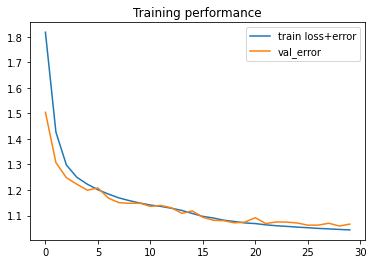

In [10]:
### Loss graph 

plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [11]:
### Confusion matrix oluşturulması 
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

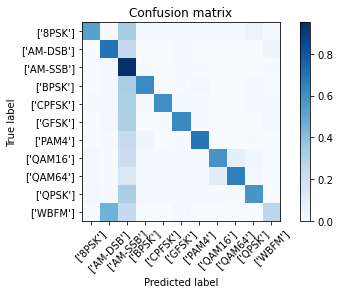

In [12]:
### Plot confusion matrix
test_Y_hat = model_cldnn.predict(X_test, batch_size=32)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#figure(figsize=(10, 8)
plot_confusion_matrix(confnorm, labels=classes)


In [13]:
temp = {}
lb = {}

for i in range(20):
    temp[-20 + (i *2)] = []
    lb[-20 + (i *2)] = []
    
for i in range(20):
    for j in range(11):
        arr = df[(classes[j][0] , (-20 + (i *2)))]
        for k in range(len(arr)) : temp [-20 + (i *2 )].append(arr[k])
        for k in range(len(df[classes[j][0], -20 + ( i*2)])): lb[-20 + (i*2)].append(classes[j][0])

Overall Accuracy:  0.0945
Overall Accuracy:  0.099
Overall Accuracy:  0.0955
Overall Accuracy:  0.1245
Overall Accuracy:  0.143
Overall Accuracy:  0.2455
Overall Accuracy:  0.3845
Overall Accuracy:  0.596
Overall Accuracy:  0.74
Overall Accuracy:  0.856
Overall Accuracy:  0.886
Overall Accuracy:  0.923
Overall Accuracy:  0.929
Overall Accuracy:  0.9315
Overall Accuracy:  0.925
Overall Accuracy:  0.93
Overall Accuracy:  0.9255
Overall Accuracy:  0.9295
Overall Accuracy:  0.9315
Overall Accuracy:  0.9285


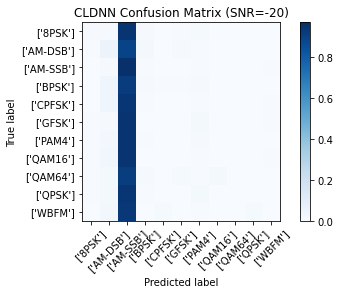

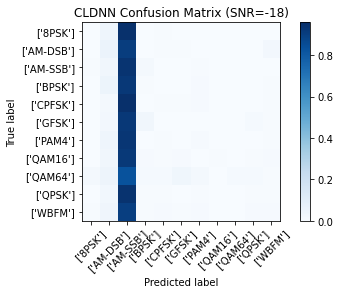

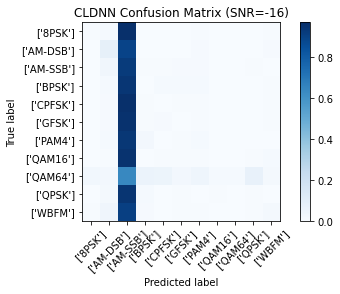

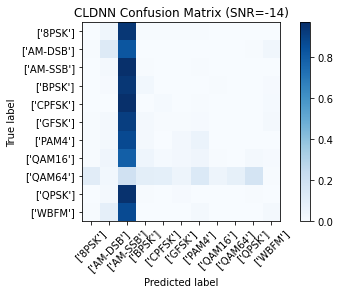

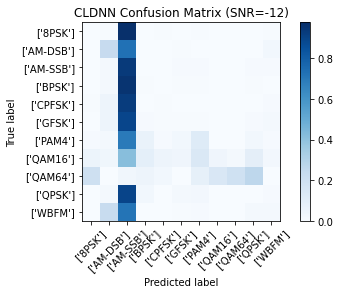

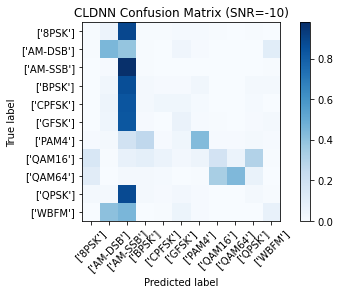

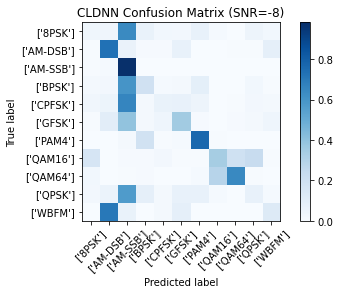

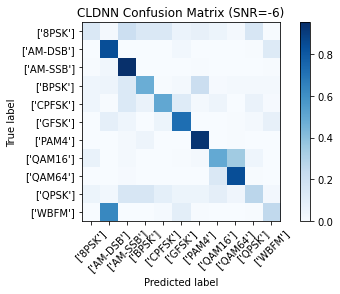

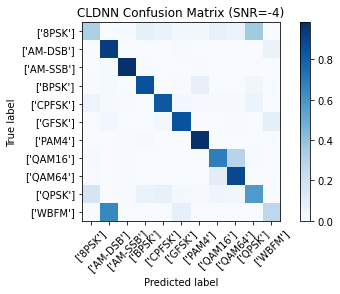

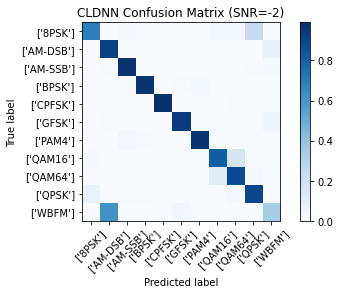

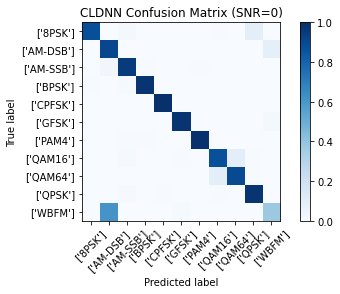

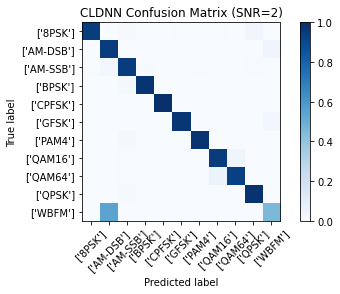

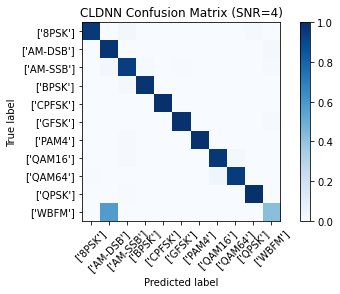

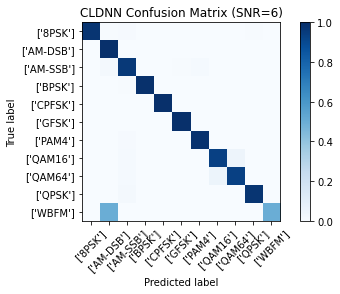

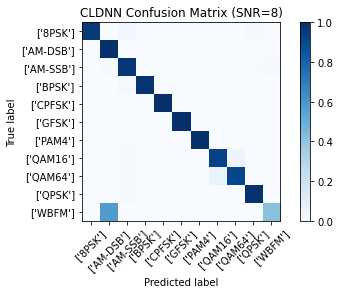

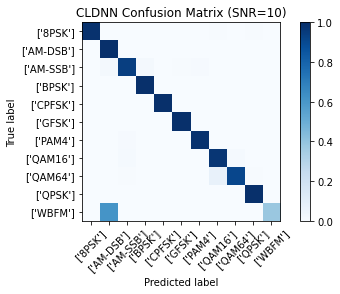

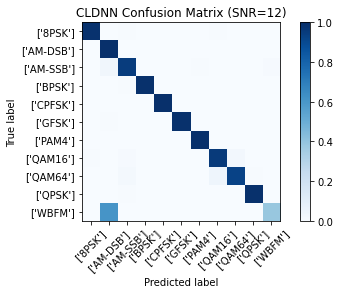

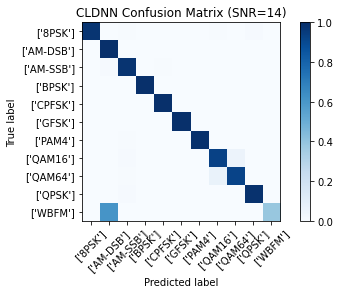

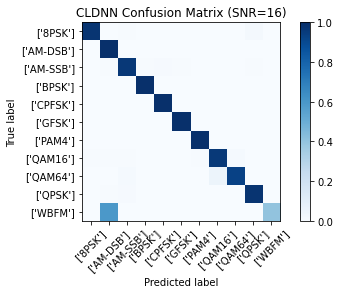

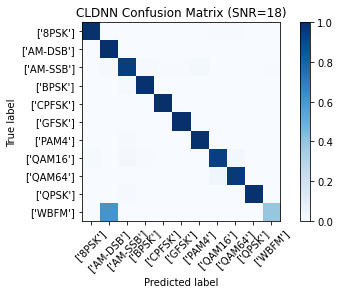

In [15]:
acc = {}
snr = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

for snr in snrs:
    temp_np = np.array(temp[snr])
    lbl_np = np.array(lb[snr])
    
    #temp_np = temp_np.reshape(temp_np.shape[0], temp_np.shape[1], temp_np.shape[2], 1)
    lbl_np = lbl_np.reshape(lbl_np.shape[0], 1)
    
    temp_i = np.random.choice(temp_np.shape[0], 2000, replace = False)
    test_X_i = temp_np[temp_i]
    test_Y_i = lbl_np[temp_i]   
    
    test_Y_i = enc.transform(test_Y_i).toarray()

    test_X_i = np.transpose(test_X_i[:,:,:],(0,2,1))
    # estimate classes
    test_Y_i_hat = model_cldnn.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = (test_Y_i[i,:].tolist()).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="CLDNN Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)